In [1]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
from agent import DQN
import pandas as pd
from scipy.spatial.distance import pdist
import random

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
save_path = Path("save")
save_path.exists()

True

### Left/Right Agents Data

In [4]:
data_dir_lr = save_path / "7-8-LR"
data_dir_lr.exists()

True

In [5]:
data_path_lr = data_dir_lr / "data.tar"
data_path_lr.exists()

True

In [6]:
data_dict_lr = torch.load(data_path_lr, weights_only=False, map_location=DEVICE)
data_dict_lr.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

### East/West Agents Data

In [7]:
data_dir_ew = save_path / "7-8-EW"
data_dir_ew.exists()

True

In [8]:
data_path_ew = data_dir_ew / "data.tar"
data_path_ew.exists()

True

In [9]:
data_dict_ew = torch.load(data_path_ew, weights_only=False, map_location=DEVICE)
data_dict_ew.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

### Loading General Model (ASSUMING MODEL ARCH. IS SAME ACROSS CAT.)

In [10]:
parameters = data_dict_ew['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [11]:
model = DQN(n_observations, n_actions, n_units)

## QQ Plots

In [12]:
# Helper Function for getting cluster nodes

def get_cluster_members(Z, cluster_idx, n_leaves):
    """Returns the leaf indices in a cluster"""
    if cluster_idx < n_leaves:
        return [int(cluster_idx)]
    else:
        c1, c2 = int(Z[cluster_idx - n_leaves][0]), int(Z[cluster_idx - n_leaves][1])
        return get_cluster_members(Z, c1, n_leaves) + get_cluster_members(Z, c2, n_leaves)

In [13]:
all_cluster_dfs = {}

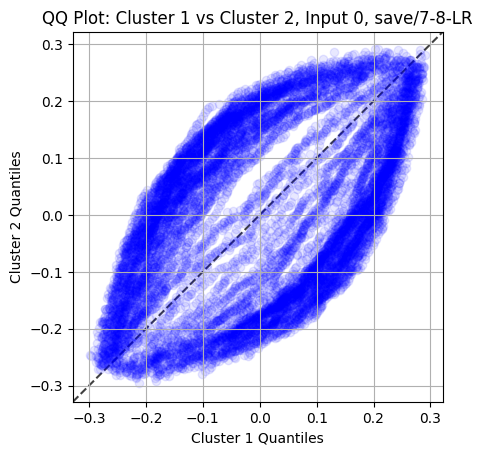

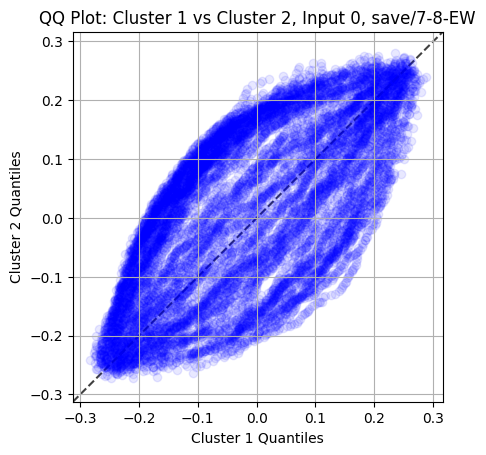

In [14]:
num_agents = 100
layer = 0 # which layer you want to look at
node_idx = 0 # which node you want to look at
incoming = True # whether you want to cluster based on incoming or outgoing weights
cluster_idx = 510 # which cluster joining you want to look at ; 510 is the top ; 509 would be one side, 508 the other

#rmse_df_508 = pd.DataFrame() # DataFrame to store RMSE for each input -- each QQ plot has an RMSE -- measures quantile differences

#rmse_list = []

for cat in [data_dir_lr, data_dir_ew]:

    fig, ax = plt.subplots()

    for i in range(num_agents):
        
        # Loading Agent Model
        model_path = cat / f'trained-agent-state-{i}.pt'
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
        model.eval()

        # Extracting Model Weights
        state_dict = model.state_dict()
        layer0_weights = state_dict['mlp.0.weight']
        layer1_weights = state_dict['mlp.1.weight']
        layer2_weights = state_dict['mlp.3.weight']
        layer3_weights = state_dict['mlp.5.weight']
        layer4_weights = state_dict['mlp.7.weight']
        weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]

        # Perform Hierarchical Clustering for Agent Weights
        if incoming:
            W = weights[layer].detach().numpy()
        else:
            W = weights[layer].detach().numpy().T
        distance_matrix = pdist(W, metric='euclidean')
        linked = linkage(distance_matrix, method='ward')
        first_cluster_id = int(linked[cluster_idx][0])
        second_cluster_id = int(linked[cluster_idx][1])

        # Plot dendrogram
        # plt.figure(figsize=(10, 5))
        # dendrogram(linked)
        # plt.title(f"Hierarchical Clustering of Nodes in Layer {layer} - Agent {i}", fontsize=20)
        # plt.xlabel("Node Index", fontsize=15)
        # plt.ylabel("Distance", fontsize=15)
        # plt.savefig('figures/hierclusteringlayer0a3.png', dpi=300)
        # plt.show()

        # Extract Nodes of Each Cluster
        n = W.shape[0]
        first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
        cluster_weights = W[first_cluster_nodes]
        cluster_1_weights = [sublist[node_idx] for sublist in cluster_weights]
        second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
        cluster_weights = W[second_cluster_nodes]
        cluster_2_weights = [sublist[node_idx] for sublist in cluster_weights]

        # Plot the QQ Plot of Cluster Distributions
        quantiles = np.linspace(0.01, 0.99, 100)
        q0 = np.quantile(cluster_1_weights, quantiles)
        q1 = np.quantile(cluster_2_weights, quantiles)
        
        ax.scatter(q0, q1, marker='o', color='blue', alpha=0.09)

        #rmse = np.sqrt(np.mean((q1 - q0) ** 2)) # computes quantile difference
        #rmse_list.append(rmse)
        
    #rmse_df_508[f'Input {node_idx}'] = rmse_list
    #all_cluster_dfs['508'] = rmse_df_508

    lims = [
        min(plt.xlim()[0], plt.ylim()[0]),  # smallest of x/y lower limits
        max(plt.xlim()[1], plt.ylim()[1])   # largest of x/y upper limits
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)  # y = x line
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('Cluster 1 Quantiles')
    ax.set_ylabel('Cluster 2 Quantiles')
    ax.set_title(f'QQ Plot: Cluster 1 vs Cluster 2, Input {node_idx}, {cat}')
    ax.grid(True)
    ax.set_aspect('equal')
    #plt.savefig(f'figures/qqplots{num_agents}i{node_idx}.png', dpi=300)
    plt.show()

In [15]:
all_node_indices = list(range(512))
print(all_node_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

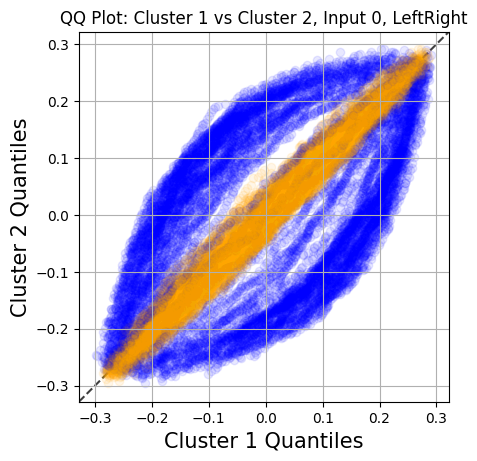

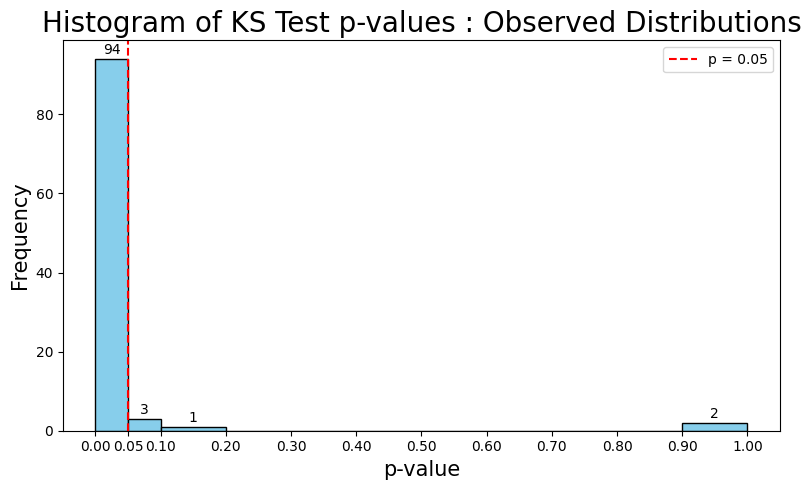

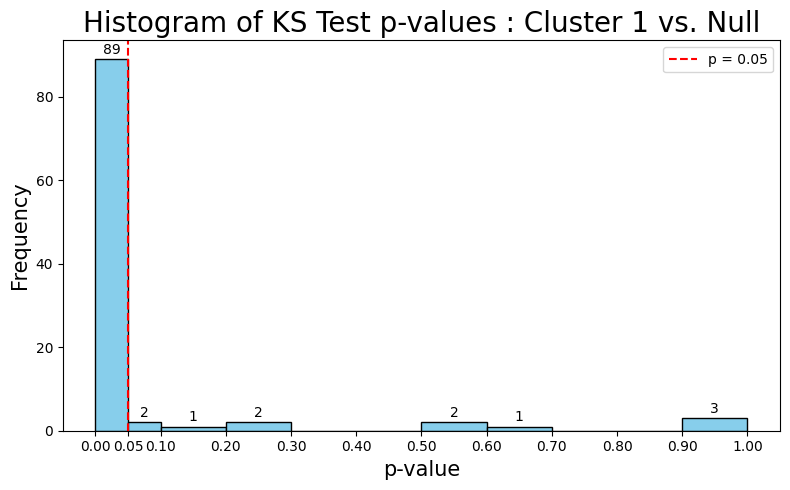

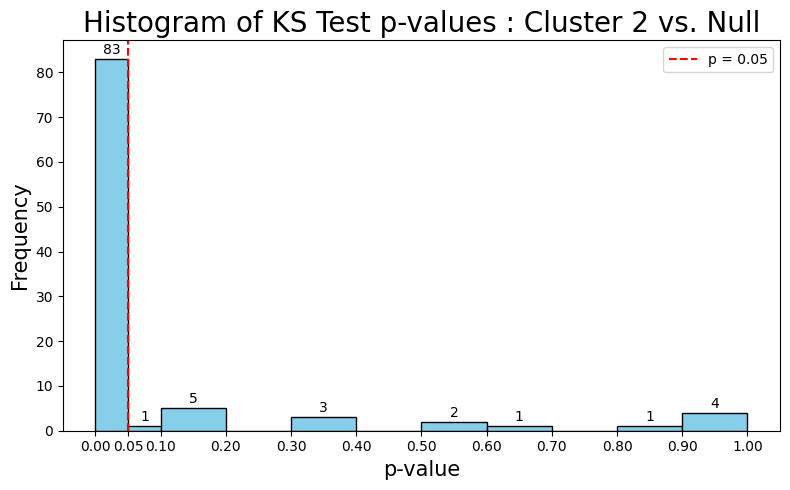

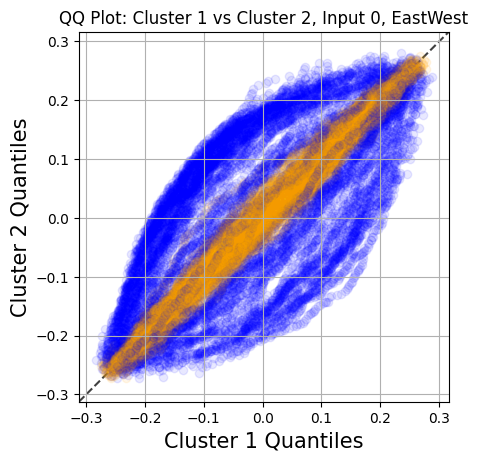

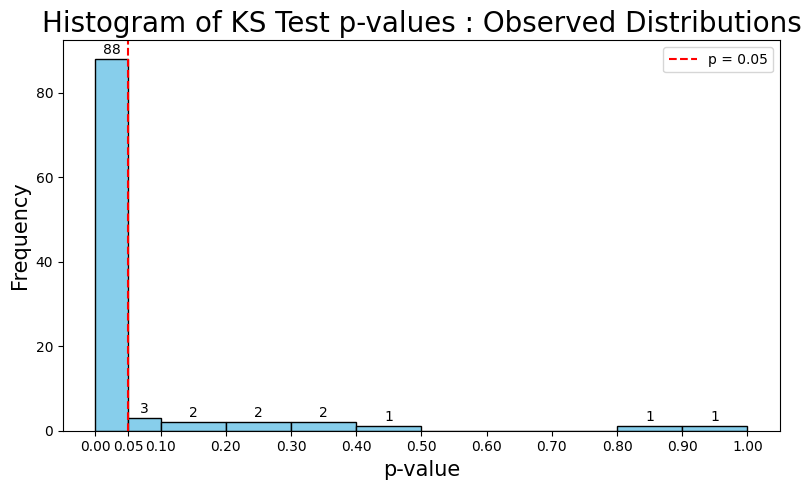

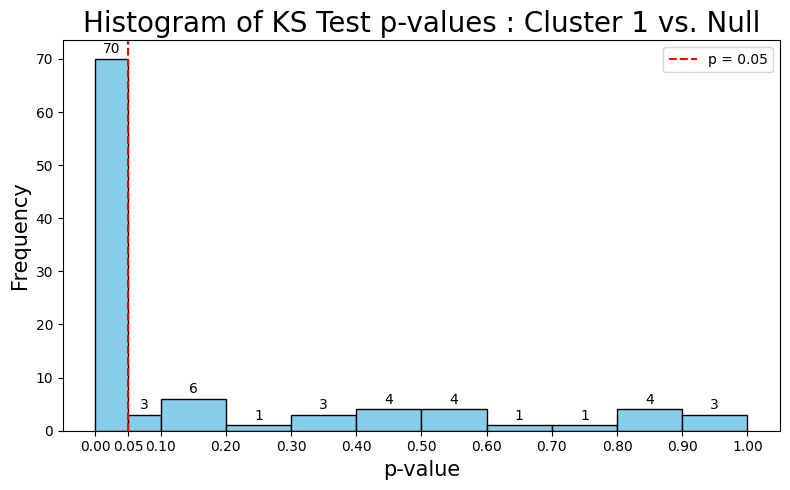

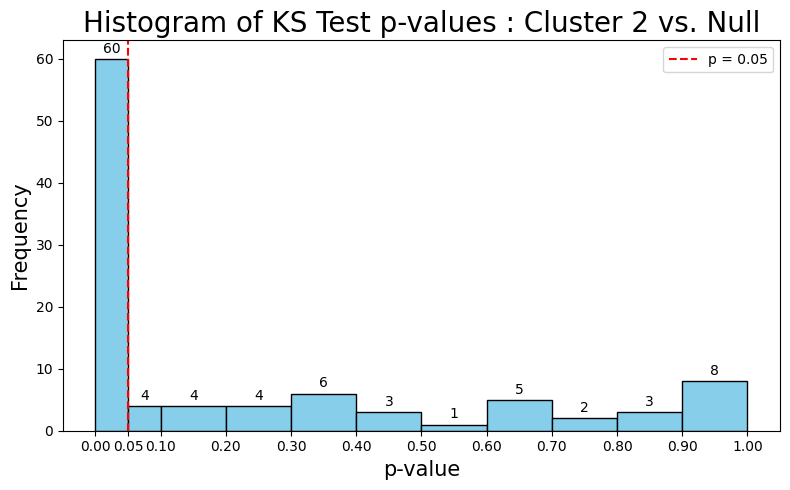

In [38]:
# QUESTION : could also cluster on "just" a particular input, instead of considering all inputs for the clustering?

from scipy.stats import ks_2samp

num_agents = 100
layer = 0 # which layer you want to look at
node_idx = 0 # which node you want to look at
incoming = True # whether you want to cluster based on incoming or outgoing weights
cluster_idx = 510 # which cluster joining you want to look at ; 510 is the top ; 509 would be one side, 508 the other

#rmse_df_508 = pd.DataFrame() # DataFrame to store RMSE for each input -- each QQ plot has an RMSE -- measures quantile differences

#rmse_list = []

# all_c1_p = []
# all_c2_p = []
for cat in [data_dir_lr, data_dir_ew]:

    

    fig, ax = plt.subplots()

    ks_obs = []
    p_obs = []

    ks_c1 = []
    p_c1 = []

    ks_c2 = []
    p_c2 = []

    for i in range(num_agents):
        
        # Loading Agent Model
        model_path = cat / f'trained-agent-state-{i}.pt'
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
        model.eval()

        # Extracting Model Weights
        state_dict = model.state_dict()
        layer0_weights = state_dict['mlp.0.weight']
        layer1_weights = state_dict['mlp.1.weight']
        layer2_weights = state_dict['mlp.3.weight']
        layer3_weights = state_dict['mlp.5.weight']
        layer4_weights = state_dict['mlp.7.weight']
        weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]

        # Perform Hierarchical Clustering for Agent Weights
        if incoming:
            W = weights[layer].detach().numpy()
        else:
            W = weights[layer].detach().numpy().T
        distance_matrix = pdist(W, metric='euclidean')
        linked = linkage(distance_matrix, method='ward')
        first_cluster_id = int(linked[cluster_idx][0])
        second_cluster_id = int(linked[cluster_idx][1])

        # Plot dendrogram
        # plt.figure(figsize=(10, 5))
        # dendrogram(linked)
        # plt.title(f"Hierarchical Clustering of Nodes in Layer {layer} - Agent {i}", fontsize=20)
        # plt.xlabel("Node Index", fontsize=15)
        # plt.ylabel("Distance", fontsize=15)
        # plt.savefig('figures/hierclusteringlayer0a3.png', dpi=300)
        # plt.show()

        # Extract Nodes of Each Cluster
        n = W.shape[0]
        first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
        cluster_weights = W[first_cluster_nodes]
        cluster_1_weights = [sublist[node_idx] for sublist in cluster_weights]
        second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
        cluster_weights = W[second_cluster_nodes]
        cluster_2_weights = [sublist[node_idx] for sublist in cluster_weights]

        # Plot the QQ Plot of Cluster Distributions
        quantiles = np.linspace(0.01, 0.99, 100)
        q0 = np.quantile(cluster_1_weights, quantiles)
        q1 = np.quantile(cluster_2_weights, quantiles)
        
        ax.scatter(q0, q1, marker='o', color='blue', alpha=0.09, label='Observed Distribution')

        statistic, p_value = ks_2samp(cluster_1_weights, cluster_2_weights)
        ks_obs.append(statistic)
        p_obs.append(p_value)

        #rmse = np.sqrt(np.mean((q1 - q0) ** 2)) # computes quantile difference
        #rmse_list.append(rmse)



        # TESTING NULL HYPOTHESIS -- generating clusters of random weights

        first_cluster_length = len(first_cluster_nodes)
        second_cluster_length = len(second_cluster_nodes)
        
        all_node_indices = list(range(512))
        cluster_1_null = random.sample(all_node_indices, first_cluster_length)
        cluster_2_null = list(set(all_node_indices) - set(cluster_1_null))
        random.shuffle(cluster_2_null)
        assert len(cluster_2_null) == second_cluster_length

        cluster_weights = W[cluster_1_null]
        null_cluster_1_weights = [sublist[node_idx] for sublist in cluster_weights]
        cluster_weights = W[cluster_2_null]
        null_cluster_2_weights = [sublist[node_idx] for sublist in cluster_weights]

        # Plot the QQ Plot of Cluster Distributions
        null_q0 = np.quantile(null_cluster_1_weights, quantiles)
        null_q1 = np.quantile(null_cluster_2_weights, quantiles)
        
        ax.scatter(null_q0, null_q1, marker='o', color='orange', alpha=0.09, label = 'Null Distribution')

        c1_statistic, c1_p_value = ks_2samp(cluster_1_weights, null_cluster_1_weights)
        c2_statistic, c2_p_value = ks_2samp(cluster_2_weights, null_cluster_2_weights)

        ks_c1.append(c1_statistic)
        p_c1.append(c1_p_value)

        ks_c2.append(c2_statistic)
        p_c2.append(c2_p_value)


    #rmse_df_508[f'Input {node_idx}'] = rmse_list
    #all_cluster_dfs['508'] = rmse_df_508

    lims = [
        min(plt.xlim()[0], plt.ylim()[0]),  # smallest of x/y lower limits
        max(plt.xlim()[1], plt.ylim()[1])   # largest of x/y upper limits
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)  # y = x line
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('Cluster 1 Quantiles', fontsize=15)
    ax.set_ylabel('Cluster 2 Quantiles', fontsize=15)
    if cat == data_dir_lr:
        task_label = 'LeftRight'
    else:
        task_label = 'EastWest'
    ax.set_title(f'QQ Plot: Cluster 1 vs Cluster 2, Input {node_idx}, {task_label}')
    ax.grid(True)
    ax.set_aspect('equal')
    #plt.savefig(f'figures/qqplots{task_label}i{node_idx}.png', dpi=300)
    plt.show()



    for dist in [p_obs, p_c1, p_c2]:

        # Define custom bins with one for p < 0.05
        bins = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

        # Create histogram
        fig, ax = plt.subplots(figsize=(8, 5))
        counts, bin_edges, patches = ax.hist(dist, bins=bins, edgecolor='black', color='skyblue')

        # Add frequency labels above each bar
        for count, patch in zip(counts, patches):
            height = patch.get_height()
            if height > 0:
                ax.text(patch.get_x() + patch.get_width() / 2, height + 0.5,
                        f'{int(count)}', ha='center', va='bottom', fontsize=10)

        # Add red line at p = 0.05
        ax.axvline(0.05, color='red', linestyle='--', label='p = 0.05')

        # Labels and legend
        ax.set_xticks(bins)
        ax.set_xlabel('p-value', fontsize=15)
        ax.set_ylabel('Frequency', fontsize=15)
        if dist == p_obs:
            p_label = 'Observed Distributions'
        elif dist == p_c1:
            p_label = 'Cluster 1 vs. Null'
        else:
            p_label = 'Cluster 2 vs. Null'
        ax.set_title(f'Histogram of KS Test p-values : {p_label}', fontsize=20)
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'figures/{task_label}kstest{p_label}i0.png', dpi=300, bbox_inches='tight')
        plt.show()

    # all_c1_p.append(p_c1)
    # all_c2_p.append(p_c2)
